# Deep Convolutional GANs

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
from scipy.io import loadmat

import pickle as pkl
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf

%matplotlib inline
%config InlineBackend.figure_format='retina'

## Getting Data

In [2]:
class DataDownloader:

    def download_data(self, data_url, data_dir, train_datafile, test_datafile):
        if not isdir(data_dir):
            raise Exception("Data directory doesn't exist!")
        
        class DLProgress(tqdm):
            last_block = 0
            
            def hook(self, block_num=1, block_size=1, total_size=None):
                self.total = total_size
                self.update((block_num-self.last_block)*block_size)
                self.last_block = block_num
        
        if not isfile(train_datafile):
            with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
                urlretrieve(data_url, train_datafile, pbar.hook)
        
        if not isfile(test_datafile):
            with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Testing Set') as pbar:
                urlretrieve(data_url, test_datafile, pbar.hook)

In [3]:
class DataLoader:
    
    def load_data(self, train_datafile, test_datafile):
        trainset = loadmat(train_datafile)
        testset = loadmat(test_datafile)
        return (trainset, testset)

In [4]:
!mkdir data

In [5]:
data_url = 'http://ufldl.stanford.edu/housenumbers/train_32x32.mat'
data_dir = 'data/'
train_datafile = data_dir + 'train_32x32.mat'
test_datafile = data_dir + 'test_32x32.mat'

In [6]:
dataDownloader = DataDownloader()

dataDownloader.download_data(data_url, data_dir, train_datafile, test_datafile)

SVHN Training Set: 182MB [00:03, 46.1MB/s]                            
SVHN Testing Set: 182MB [00:03, 46.2MB/s]                            


In [7]:
dataLoader = DataLoader()

trainset, testset = dataLoader.load_data(train_datafile, test_datafile)

## Displaying Images

In [8]:
class ImageDisplayer:
    
    def show_trainset_samples(self, trainset):
        idx = np.random.randint(0, trainset['X'].shape[3], size=36)
        fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
        
        for ii, ax in zip(idx, axes.flatten()):
            ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
            
        plt.subplots_adjust(wspace=0, hspace=0)
        
        plt.show()
        
    
    def show_generated_samples(self, epoch, samples, nrows, ncols, figsize=(5,5)):
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True,
                                 figsize=figsize)
        
        for ax, img in zip(axes.flatten(), samples[epoch]):
            ax.axis('off')
            img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
            ax.set_adjustable('box-forced')
            im = ax.imshow(img, aspect='equal')

        plt.subplots_adjust(wspace=0, hspace=0)
        
        #return fig, axes
        
        plt.show()

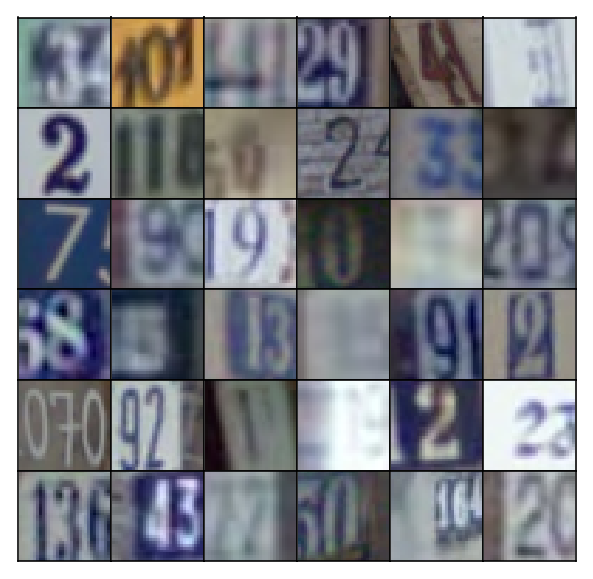

In [9]:
imageDisplayer = ImageDisplayer()

imageDisplayer.show_trainset_samples(trainset)

## Preparing Dataset

In [10]:
class Dataset:
    
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = self.scale
        else:
            self.scaler = scale_func
            
        self.shuffle = shuffle
        
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(dataset.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), y
            
            
    def scale(self, x, feature_range=(-1, 1)):
        # scale to (0, 1)
        x = ((x - x.min())/(255 - x.min()))

        # scale to feature_range
        min, max = feature_range
        x = x * (max - min) + min
        return x

In [11]:
dataset = Dataset(trainset, testset)

## Building DCGAN Model

In [12]:
class DCGANBuilder:
    
    def model_inputs(self, real_dim, z_dim):
        """
        Build model input placeholders.
        """
        inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
        inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
        return (inputs_real, inputs_z)
    
    
    def generator(self, z, output_dim, reuse=False, alpha=0.2, training=True):
        """
        Build generator network.
        """
        with tf.variable_scope('generator', reuse=reuse):
            
            # First, fully-connected layer
            fc1 = tf.layers.dense(z, 4*4*512)
            
            # Reshape it to start the convolutional stack
            rs2 = tf.reshape(fc1, (-1, 4, 4, 512))
            # Apply batch normalization
            bn2 = tf.layers.batch_normalization(rs2, training=training)
            # Apply Leaky ReLU
            relu2 = tf.maximum(alpha*bn2, bn2)
            # 4x4x512 now
            
            # Apply transposed convolution
            conv3 = tf.layers.conv2d_transpose(relu2, 256, 5, strides=2, padding='same')
            # Apply batch normalization
            bn3 = tf.layers.batch_normalization(conv3, training=training)
            # Apply Leaky ReLU
            relu3 = tf.maximum(alpha*bn3, bn3)
            # 8x8x256 now
            
            # Apply transposed convolution
            conv4 = tf.layers.conv2d_transpose(relu3, 128, 5, strides=2, padding='same')
            # Apply batch normalization
            bn4 = tf.layers.batch_normalization(conv4, training=training)
            # Apply Leaky ReLU
            relu4 = tf.maximum(alpha*bn4, bn4)
            # 16x16x128 now
            
            # Output layer
            logits = tf.layers.conv2d_transpose(relu4, output_dim, 5, strides=2, padding='same')
            # 32x32x3 now
            
            # Apply tanh
            out = tf.tanh(logits)
            
            return out
        
        
    def discriminator(self, x, reuse=False, alpha=0.2):
        """
        Build discriminator network.
        """
        with tf.variable_scope('discriminator', reuse=reuse):
            
            # Input is 32x32x3
            
            # Apply convolution
            conv1 = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
            # Apply Leaky ReLU
            relu1 = tf.maximum(alpha*conv1, conv1)
            # 16x16x64 now
            
            # Apply convolution
            conv2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
            # Apply batch normalization
            bn2 = tf.layers.batch_normalization(conv2, training=True)
            # Apply Leaky ReLU
            relu2 = tf.maximum(alpha*bn2, bn2)
            # 8x8x128 now
            
            # Apply convolution
            conv3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
            # Apply batch normalization
            bn3 = tf.layers.batch_normalization(conv3, training=True)
            # Apply Leaky ReLU
            relu3 = tf.maximum(alpha*bn3, bn3)
            # 4x4x256 now
            
            # Flatten
            flat = tf.reshape(relu3, (-1, 4*4*256))
            
            # Fully-connected output layer
            logits = tf.layers.dense(flat, 1)
            
            # Apply sigmoid
            out = tf.sigmoid(logits)
            
            return out, logits
    
    
    def model_loss(self, input_real, input_z, output_dim, alpha=0.2):
        """
        Get the loss for the discriminator and generator.
        
        :param input_real: Images from the real dataset
        :param input_z: Z input
        :param out_channel_dim: The number of channels in the output image
        :return: A tuple of (discriminator loss, generator loss)
        """
        g_model = self.generator(input_z, output_dim, alpha=alpha)
        d_model_real, d_logits_real = self.discriminator(input_real, alpha=alpha)
        d_model_fake, d_logits_fake = self.discriminator(g_model, reuse=True, alpha=alpha)
        
        def get_loss(logits, labels):
            return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, 
                                                                          labels=labels))
        
        d_loss_real = get_loss(d_logits_real, tf.ones_like(d_model_real))
        d_loss_fake = get_loss(d_logits_fake, tf.zeros_like(d_model_fake))
        g_loss = get_loss(d_logits_fake, tf.ones_like(d_model_fake))
        
        d_loss = d_loss_real + d_loss_fake
        
        return (d_loss, g_loss)

    
    def model_opt(self, d_loss, g_loss, learning_rate, beta1):
        """
        Get optimization operations.
        
        :param d_loss: Discriminator loss Tensor
        :param g_loss: Generator loss Tensor
        :param learning_rate: Learning Rate Placeholder
        :param beta1: The exponential decay rate for the 1st moment in the optimizer
        :return: A tuple of (discriminator training operation, generator training operation)
        """
        # Get weights and bias to update
        t_vars = tf.trainable_variables()
        d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
        g_vars = [var for var in t_vars if var.name.startswith('generator')]
        
        # Optimize
        with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
            d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1)\
                            .minimize(d_loss, var_list=d_vars)
            g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1)\
                            .minimize(g_loss, var_list=g_vars)    
        
        return (d_train_opt, g_train_opt)

In [13]:
class DCGAN:
    
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        """
        Build GAN.
        """
        tf.reset_default_graph()
        
        dcganBuilder = DCGANBuilder()
        
        self.input_real, self.input_z = dcganBuilder.model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = dcganBuilder.model_loss(self.input_real, 
                                                           self.input_z,
                                                           real_size[2], 
                                                           alpha=alpha)
        
        self.d_opt, self.g_opt = dcganBuilder.model_opt(self.d_loss, 
                                                        self.g_loss, 
                                                        learning_rate, 
                                                        beta1)

In [14]:
real_size = (32,32,3)
z_size = 100
learning_rate = 0.0002
alpha = 0.2
beta1 = 0.5

In [15]:
dcgan = DCGAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

## Training DCGAN Model

In [23]:
class DCGANTrainer:
    
    def train_model(self, dcgan, dataset):
        """
        Train DCGAN model.
        """
        
        sample_z = np.random.uniform(-1, 1, size=(72, z_size))
        
        losses, samples = [], []
        steps = 0
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            
            saver = tf.train.Saver()
            
            dcganBuilder = DCGANBuilder()
            imageDisplayer = ImageDisplayer()
            
            for e in range(epochs):
                for x, y in dataset.batches(batch_size):
                    steps += 1
                    
                    # Sample random noise for G
                    batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
                    
                    # Run optimizers
                    _ = sess.run(dcgan.d_opt, feed_dict={dcgan.input_real: x,
                                                         dcgan.input_z: batch_z})
                    _ = sess.run(dcgan.g_opt, feed_dict={dcgan.input_z: batch_z,
                                                         dcgan.input_real: x})
                    
                    if steps % print_every == 0:
                        # At the end of each epoch, get the losses and print them out
                        train_loss_d = dcgan.d_loss.eval({dcgan.input_z: batch_z,
                                                          dcgan.input_real: x})
                        train_loss_g = dcgan.g_loss.eval({dcgan.input_z: batch_z})
                        
                        print("Epoch {}/{}...".format(e+1, epochs),
                              "Step {}...".format(steps),
                              "Discriminator Loss: {:.4f}...".format(train_loss_d),
                              "Generator Loss: {:.4f}".format(train_loss_g))
                        
                        # Save losses to view after training
                        losses.append((train_loss_d, train_loss_g))
                
                # Generate samples per each ecpoh
                gen_samples = sess.run(
                    dcganBuilder.generator(dcgan.input_z, 3, reuse=True, training=False),
                    feed_dict={dcgan.input_z: sample_z})
                samples.append(gen_samples)
                imageDisplayer.show_generated_samples(-1, samples, 6, 12, figsize=figsize)
        
            saver.save(sess, './checkpoints/generator.ckpt')
        
        with open('samples.pkl', 'wb') as f:
            pkl.dump(samples, f)

        return (losses, samples)

In [17]:
class PlotDisplayer:
    
    def show_training_losses(self, losses):
        fig, ax = plt.subplots()
        losses = np.array(losses)
        plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
        plt.plot(losses.T[1], label='Generator', alpha=0.5)
        plt.title("Training Losses")
        plt.legend()

In [26]:
epochs = 10
batch_size = 128
print_every = 50 
show_every = 1000
figsize = (10,5)

In [19]:
!mkdir checkpoints

Epoch 1/10... Step 50... Discriminator Loss: 0.1611... Generator Loss: 2.5977
Epoch 1/10... Step 100... Discriminator Loss: 0.1137... Generator Loss: 3.4307
Epoch 1/10... Step 150... Discriminator Loss: 1.3499... Generator Loss: 1.9337
Epoch 1/10... Step 200... Discriminator Loss: 0.5161... Generator Loss: 1.8630
Epoch 1/10... Step 250... Discriminator Loss: 0.2739... Generator Loss: 2.9201
Epoch 1/10... Step 300... Discriminator Loss: 0.6049... Generator Loss: 1.5215
Epoch 1/10... Step 350... Discriminator Loss: 0.6765... Generator Loss: 1.0784
Epoch 1/10... Step 400... Discriminator Loss: 0.3074... Generator Loss: 2.4976
Epoch 1/10... Step 450... Discriminator Loss: 0.6490... Generator Loss: 1.7108
Epoch 1/10... Step 500... Discriminator Loss: 0.7352... Generator Loss: 1.0835
Epoch 1/10... Step 550... Discriminator Loss: 0.7255... Generator Loss: 1.4077


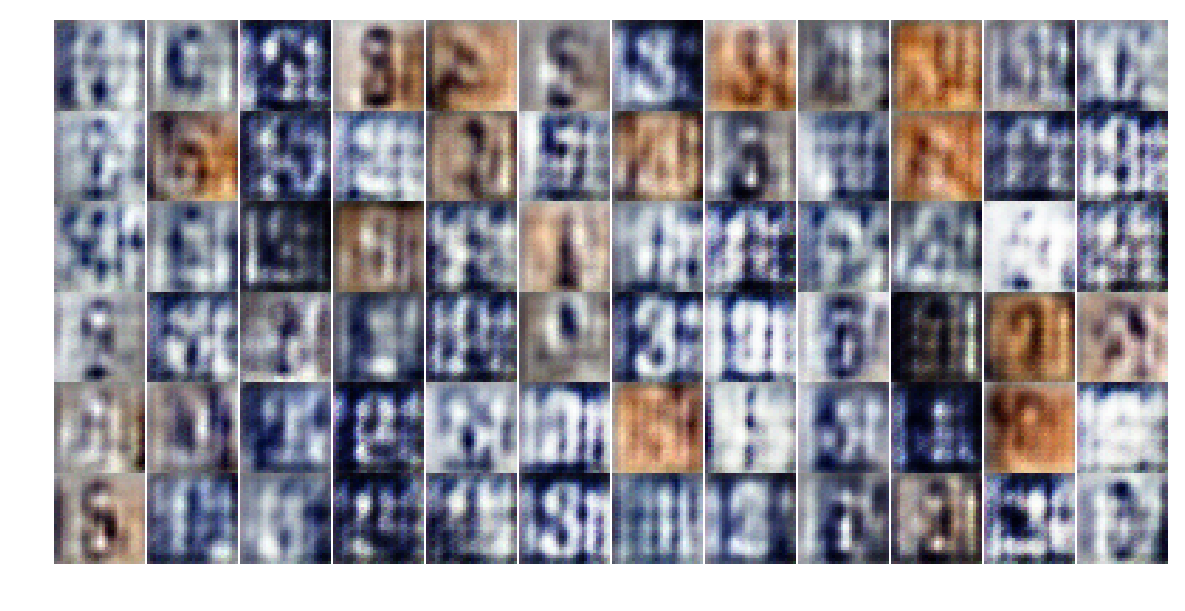

Epoch 2/10... Step 600... Discriminator Loss: 1.0086... Generator Loss: 1.1198
Epoch 2/10... Step 650... Discriminator Loss: 0.8354... Generator Loss: 1.2226
Epoch 2/10... Step 700... Discriminator Loss: 1.1596... Generator Loss: 0.8275
Epoch 2/10... Step 750... Discriminator Loss: 1.0427... Generator Loss: 1.1763
Epoch 2/10... Step 800... Discriminator Loss: 1.1643... Generator Loss: 1.0006
Epoch 2/10... Step 850... Discriminator Loss: 1.0961... Generator Loss: 1.0257
Epoch 2/10... Step 900... Discriminator Loss: 0.8593... Generator Loss: 1.3660
Epoch 2/10... Step 950... Discriminator Loss: 0.9814... Generator Loss: 1.4084
Epoch 2/10... Step 1000... Discriminator Loss: 1.2293... Generator Loss: 0.9352
Epoch 2/10... Step 1050... Discriminator Loss: 1.2480... Generator Loss: 1.0263
Epoch 2/10... Step 1100... Discriminator Loss: 1.0292... Generator Loss: 0.9432


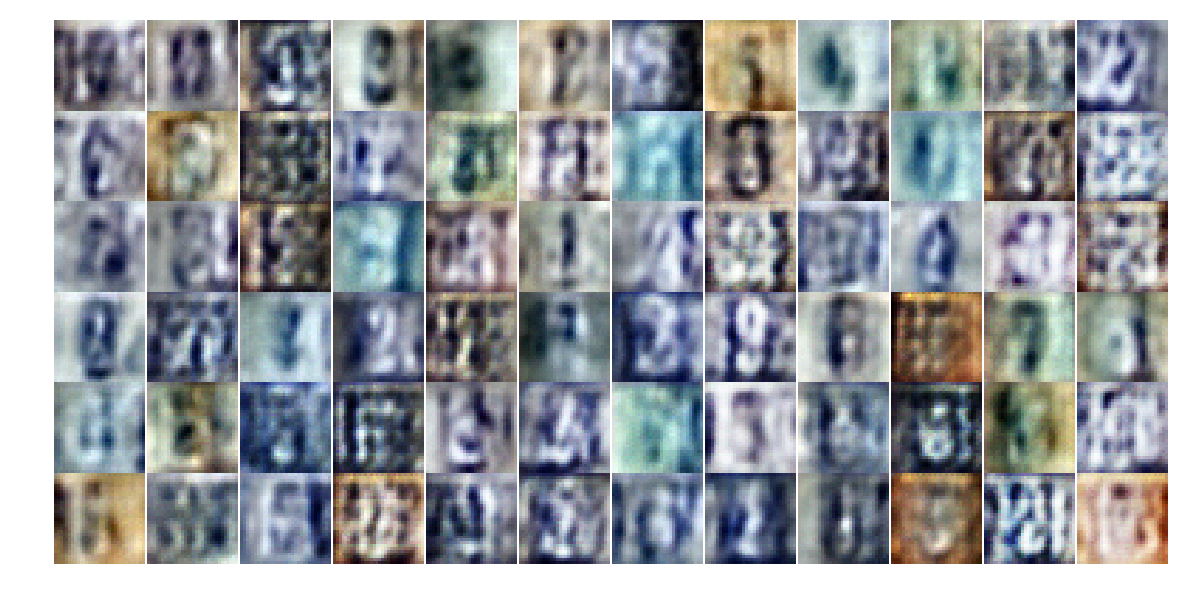

Epoch 3/10... Step 1150... Discriminator Loss: 1.0537... Generator Loss: 1.8367
Epoch 3/10... Step 1200... Discriminator Loss: 0.6918... Generator Loss: 1.4023
Epoch 3/10... Step 1250... Discriminator Loss: 0.7258... Generator Loss: 1.4645
Epoch 3/10... Step 1300... Discriminator Loss: 1.0446... Generator Loss: 0.6760
Epoch 3/10... Step 1350... Discriminator Loss: 1.1490... Generator Loss: 1.9505
Epoch 3/10... Step 1400... Discriminator Loss: 1.4796... Generator Loss: 0.3809
Epoch 3/10... Step 1450... Discriminator Loss: 1.0038... Generator Loss: 0.7695
Epoch 3/10... Step 1500... Discriminator Loss: 0.5091... Generator Loss: 2.2054
Epoch 3/10... Step 1550... Discriminator Loss: 0.4895... Generator Loss: 2.0346
Epoch 3/10... Step 1600... Discriminator Loss: 0.7677... Generator Loss: 1.5190
Epoch 3/10... Step 1650... Discriminator Loss: 1.2776... Generator Loss: 0.4880
Epoch 3/10... Step 1700... Discriminator Loss: 0.6347... Generator Loss: 1.1513


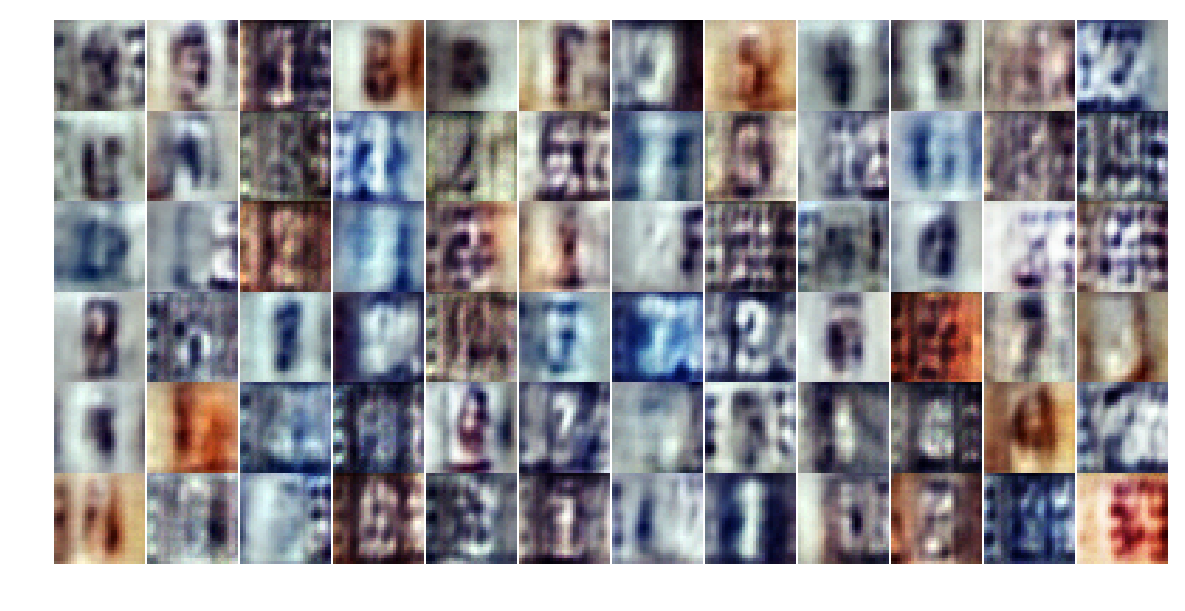

Epoch 4/10... Step 1750... Discriminator Loss: 0.4079... Generator Loss: 1.8049
Epoch 4/10... Step 1800... Discriminator Loss: 0.5642... Generator Loss: 1.4370
Epoch 4/10... Step 1850... Discriminator Loss: 0.6801... Generator Loss: 1.9267
Epoch 4/10... Step 1900... Discriminator Loss: 0.3598... Generator Loss: 2.6612
Epoch 4/10... Step 1950... Discriminator Loss: 0.5099... Generator Loss: 1.8137
Epoch 4/10... Step 2000... Discriminator Loss: 1.0930... Generator Loss: 0.6601
Epoch 4/10... Step 2050... Discriminator Loss: 0.4637... Generator Loss: 2.2388
Epoch 4/10... Step 2100... Discriminator Loss: 0.9365... Generator Loss: 0.7067
Epoch 4/10... Step 2150... Discriminator Loss: 0.4507... Generator Loss: 2.0011
Epoch 4/10... Step 2200... Discriminator Loss: 0.6395... Generator Loss: 1.4433
Epoch 4/10... Step 2250... Discriminator Loss: 0.7337... Generator Loss: 1.5681


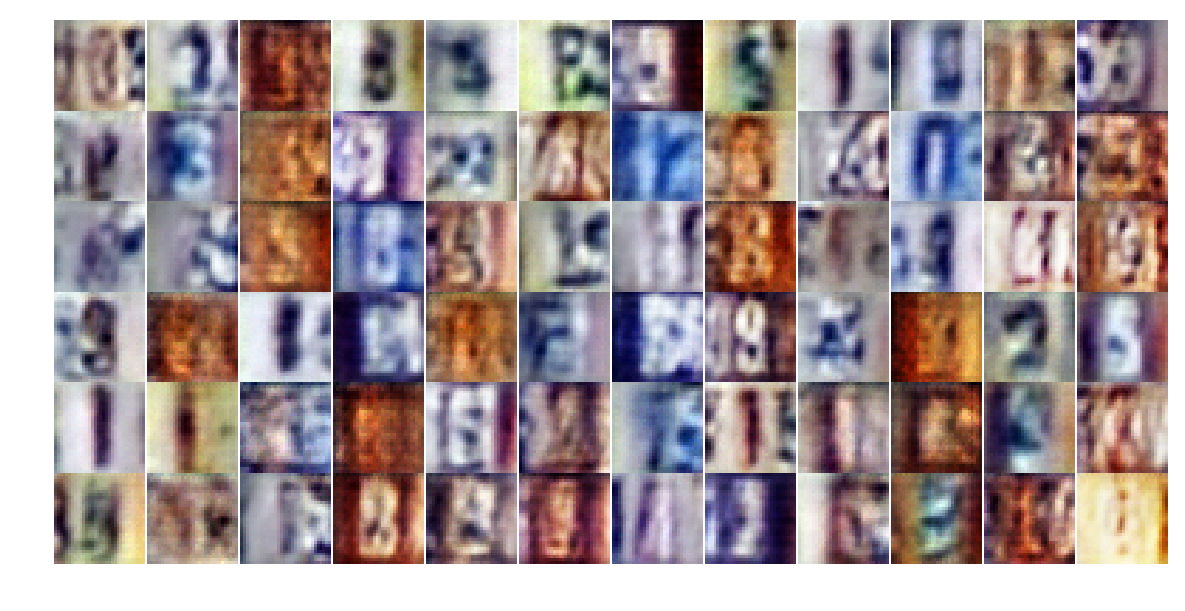

Epoch 5/10... Step 2300... Discriminator Loss: 0.5394... Generator Loss: 1.2274
Epoch 5/10... Step 2350... Discriminator Loss: 0.8453... Generator Loss: 2.7644
Epoch 5/10... Step 2400... Discriminator Loss: 0.5894... Generator Loss: 1.1927
Epoch 5/10... Step 2450... Discriminator Loss: 0.5608... Generator Loss: 2.1668
Epoch 5/10... Step 2500... Discriminator Loss: 0.5136... Generator Loss: 1.5729
Epoch 5/10... Step 2550... Discriminator Loss: 0.9432... Generator Loss: 0.6781
Epoch 5/10... Step 2600... Discriminator Loss: 0.3656... Generator Loss: 1.7790
Epoch 5/10... Step 2650... Discriminator Loss: 0.7557... Generator Loss: 0.9544
Epoch 5/10... Step 2700... Discriminator Loss: 0.6193... Generator Loss: 1.1194
Epoch 5/10... Step 2750... Discriminator Loss: 1.3743... Generator Loss: 2.5071
Epoch 5/10... Step 2800... Discriminator Loss: 0.5816... Generator Loss: 1.8470
Epoch 5/10... Step 2850... Discriminator Loss: 0.7410... Generator Loss: 0.9521


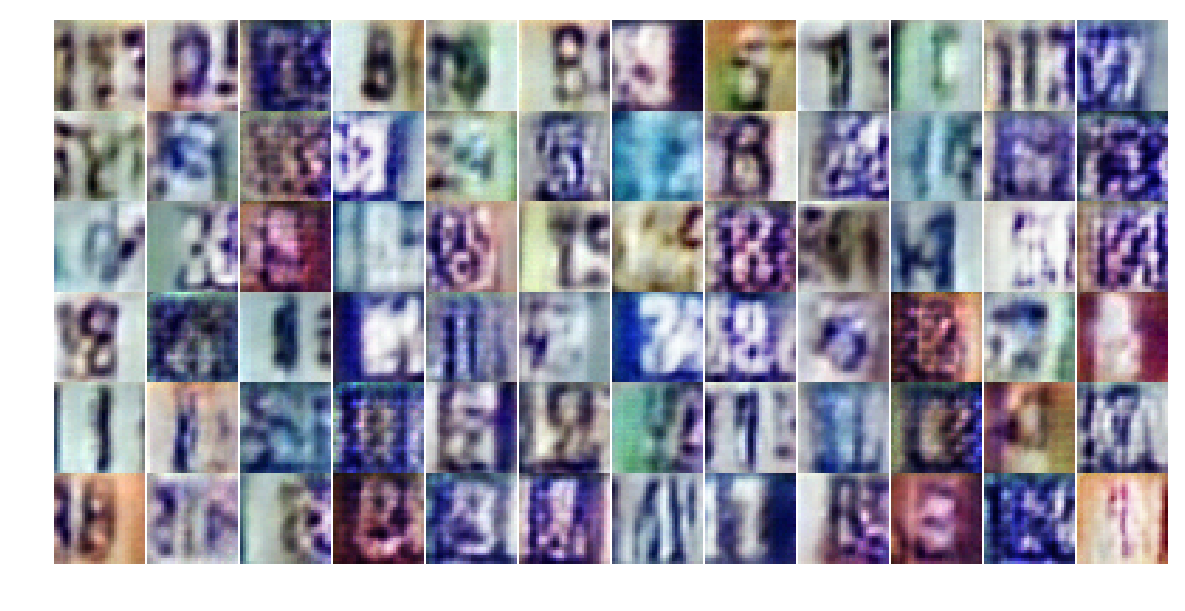

Epoch 6/10... Step 2900... Discriminator Loss: 0.6889... Generator Loss: 1.7775
Epoch 6/10... Step 2950... Discriminator Loss: 1.0168... Generator Loss: 0.6176
Epoch 6/10... Step 3000... Discriminator Loss: 0.5388... Generator Loss: 1.3779
Epoch 6/10... Step 3050... Discriminator Loss: 0.3174... Generator Loss: 2.0659
Epoch 6/10... Step 3100... Discriminator Loss: 0.9462... Generator Loss: 0.6911
Epoch 6/10... Step 3150... Discriminator Loss: 0.5129... Generator Loss: 1.8198
Epoch 6/10... Step 3200... Discriminator Loss: 0.6660... Generator Loss: 1.0364
Epoch 6/10... Step 3250... Discriminator Loss: 0.7453... Generator Loss: 0.9430
Epoch 6/10... Step 3300... Discriminator Loss: 0.6852... Generator Loss: 0.8569
Epoch 6/10... Step 3350... Discriminator Loss: 0.4814... Generator Loss: 2.1169
Epoch 6/10... Step 3400... Discriminator Loss: 2.3214... Generator Loss: 0.1552


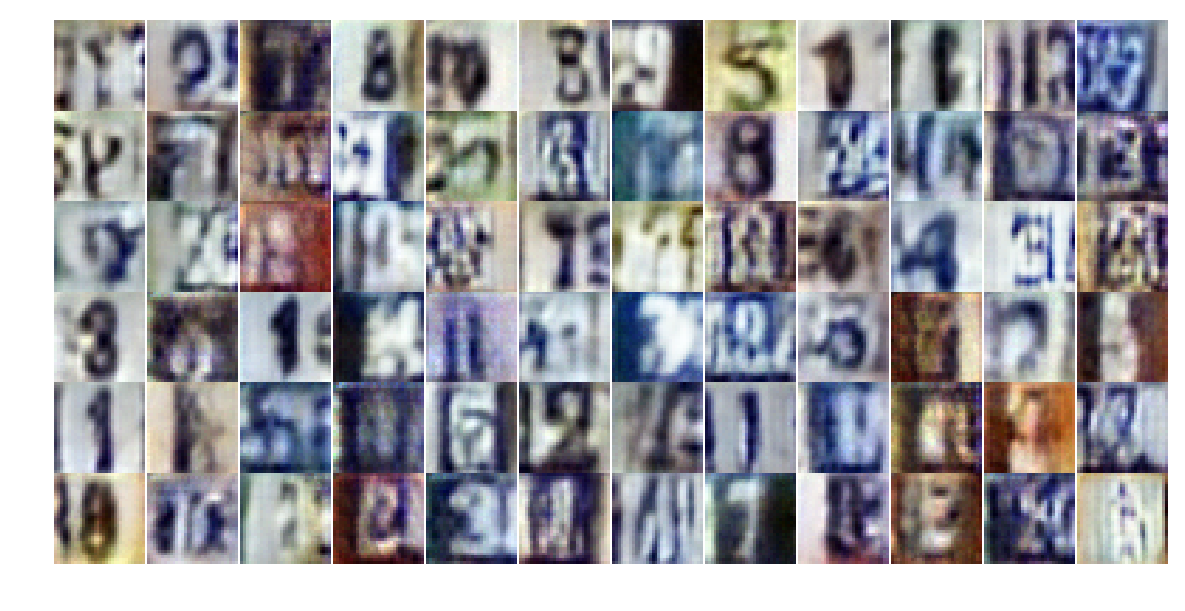

Epoch 7/10... Step 3450... Discriminator Loss: 0.7616... Generator Loss: 0.9243
Epoch 7/10... Step 3500... Discriminator Loss: 0.9811... Generator Loss: 0.6787
Epoch 7/10... Step 3550... Discriminator Loss: 0.5341... Generator Loss: 2.2777
Epoch 7/10... Step 3600... Discriminator Loss: 0.7322... Generator Loss: 1.0232
Epoch 7/10... Step 3650... Discriminator Loss: 0.5590... Generator Loss: 1.1371
Epoch 7/10... Step 3700... Discriminator Loss: 0.4807... Generator Loss: 2.0036
Epoch 7/10... Step 3750... Discriminator Loss: 0.6636... Generator Loss: 0.9959
Epoch 7/10... Step 3800... Discriminator Loss: 0.6128... Generator Loss: 2.0255
Epoch 7/10... Step 3850... Discriminator Loss: 0.7485... Generator Loss: 0.8835
Epoch 7/10... Step 3900... Discriminator Loss: 2.4313... Generator Loss: 0.2784
Epoch 7/10... Step 3950... Discriminator Loss: 0.6628... Generator Loss: 1.0719
Epoch 7/10... Step 4000... Discriminator Loss: 0.4883... Generator Loss: 1.2945


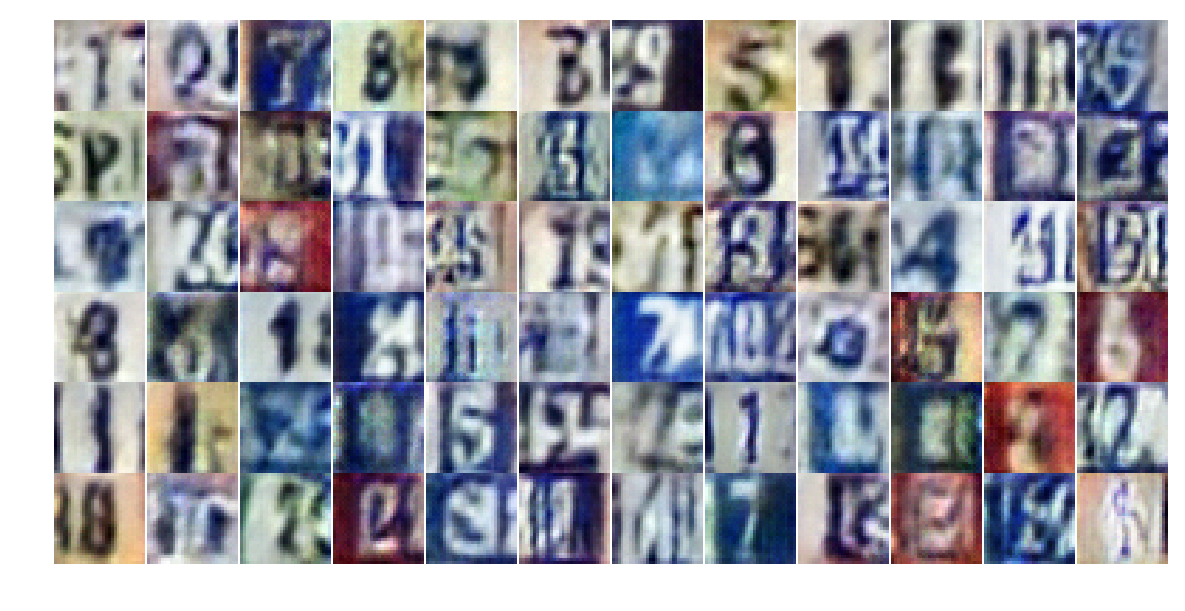

Epoch 8/10... Step 4050... Discriminator Loss: 0.5383... Generator Loss: 1.3868
Epoch 8/10... Step 4100... Discriminator Loss: 0.6298... Generator Loss: 1.1026
Epoch 8/10... Step 4150... Discriminator Loss: 0.5415... Generator Loss: 2.2431
Epoch 8/10... Step 4200... Discriminator Loss: 1.2504... Generator Loss: 0.4289
Epoch 8/10... Step 4250... Discriminator Loss: 0.5238... Generator Loss: 1.4035
Epoch 8/10... Step 4300... Discriminator Loss: 0.5744... Generator Loss: 1.2352
Epoch 8/10... Step 4350... Discriminator Loss: 1.2099... Generator Loss: 0.5393
Epoch 8/10... Step 4400... Discriminator Loss: 0.4920... Generator Loss: 1.3584
Epoch 8/10... Step 4450... Discriminator Loss: 1.3327... Generator Loss: 2.7247
Epoch 8/10... Step 4500... Discriminator Loss: 0.7383... Generator Loss: 0.8877
Epoch 8/10... Step 4550... Discriminator Loss: 0.5276... Generator Loss: 2.1866


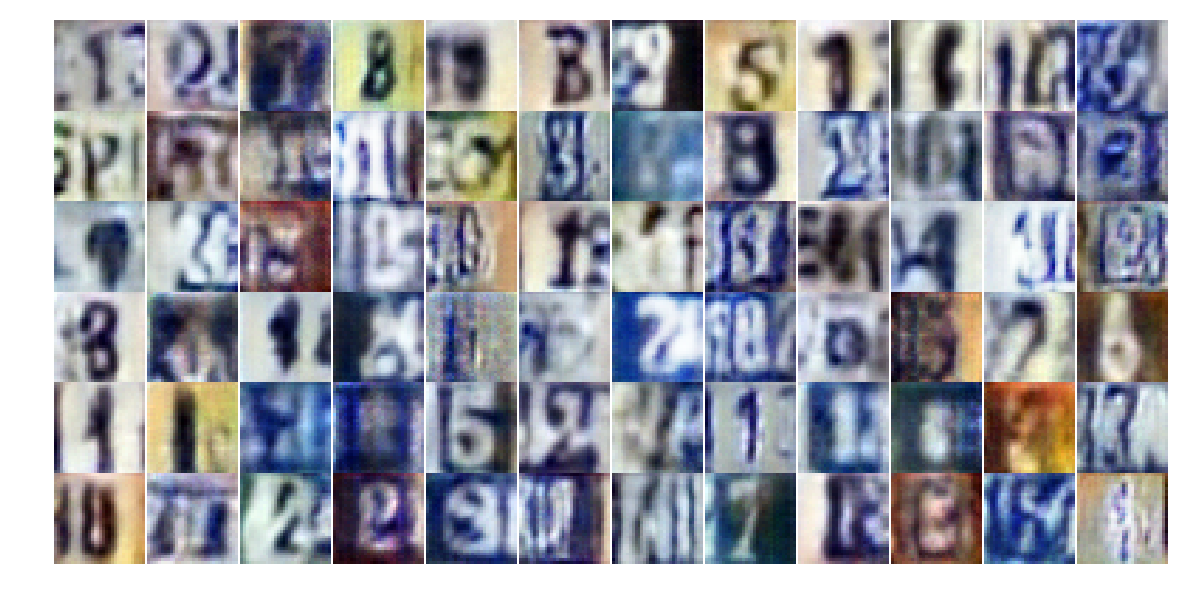

Epoch 9/10... Step 4600... Discriminator Loss: 0.9780... Generator Loss: 0.6024
Epoch 9/10... Step 4650... Discriminator Loss: 1.1305... Generator Loss: 0.5778
Epoch 9/10... Step 4700... Discriminator Loss: 0.6083... Generator Loss: 1.4221
Epoch 9/10... Step 4750... Discriminator Loss: 0.5143... Generator Loss: 1.2845
Epoch 9/10... Step 4800... Discriminator Loss: 1.2345... Generator Loss: 0.4664
Epoch 9/10... Step 4850... Discriminator Loss: 0.6352... Generator Loss: 2.1987
Epoch 9/10... Step 4900... Discriminator Loss: 0.7072... Generator Loss: 0.8886
Epoch 9/10... Step 4950... Discriminator Loss: 0.5495... Generator Loss: 1.2198
Epoch 9/10... Step 5000... Discriminator Loss: 0.4795... Generator Loss: 1.4597
Epoch 9/10... Step 5050... Discriminator Loss: 0.3383... Generator Loss: 2.1925
Epoch 9/10... Step 5100... Discriminator Loss: 0.6123... Generator Loss: 2.3357
Epoch 9/10... Step 5150... Discriminator Loss: 0.7755... Generator Loss: 1.0021


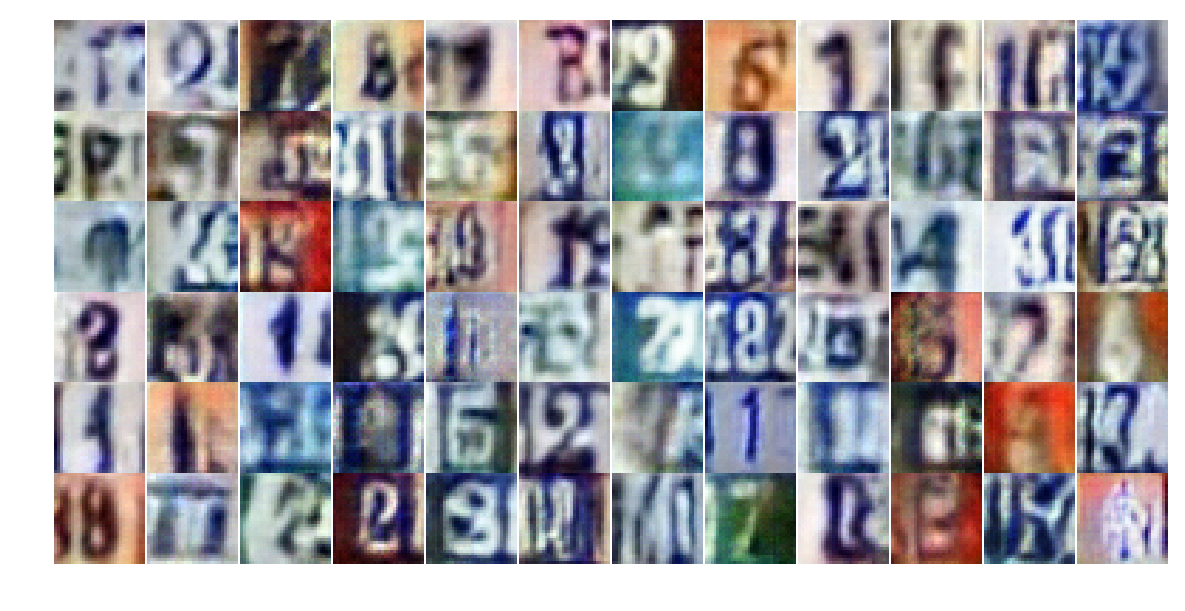

Epoch 10/10... Step 5200... Discriminator Loss: 0.9818... Generator Loss: 0.6305
Epoch 10/10... Step 5250... Discriminator Loss: 0.5355... Generator Loss: 1.4377
Epoch 10/10... Step 5300... Discriminator Loss: 0.7099... Generator Loss: 1.0376
Epoch 10/10... Step 5350... Discriminator Loss: 0.5739... Generator Loss: 1.5234
Epoch 10/10... Step 5400... Discriminator Loss: 0.3321... Generator Loss: 2.5920
Epoch 10/10... Step 5450... Discriminator Loss: 1.3290... Generator Loss: 0.3873
Epoch 10/10... Step 5500... Discriminator Loss: 0.5832... Generator Loss: 1.4073
Epoch 10/10... Step 5550... Discriminator Loss: 0.8014... Generator Loss: 0.8818
Epoch 10/10... Step 5600... Discriminator Loss: 0.5655... Generator Loss: 2.2031
Epoch 10/10... Step 5650... Discriminator Loss: 0.5002... Generator Loss: 1.8746
Epoch 10/10... Step 5700... Discriminator Loss: 1.0206... Generator Loss: 1.7957


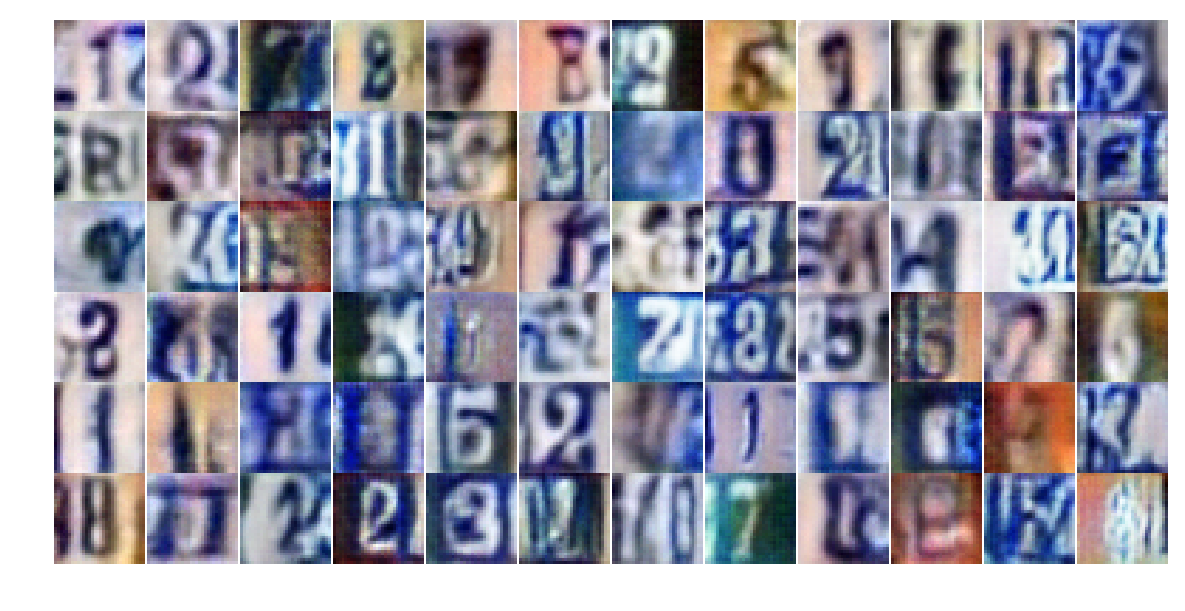

In [27]:
dcganTrainer = DCGANTrainer() 

losses, samples = dcganTrainer.train_model(dcgan, dataset)

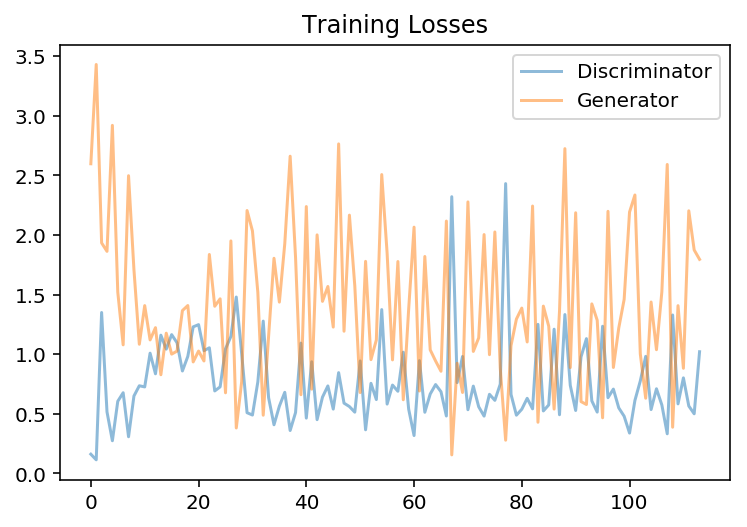

In [28]:
plotDisplayer = PlotDisplayer()

plotDisplayer.show_training_losses(losses)

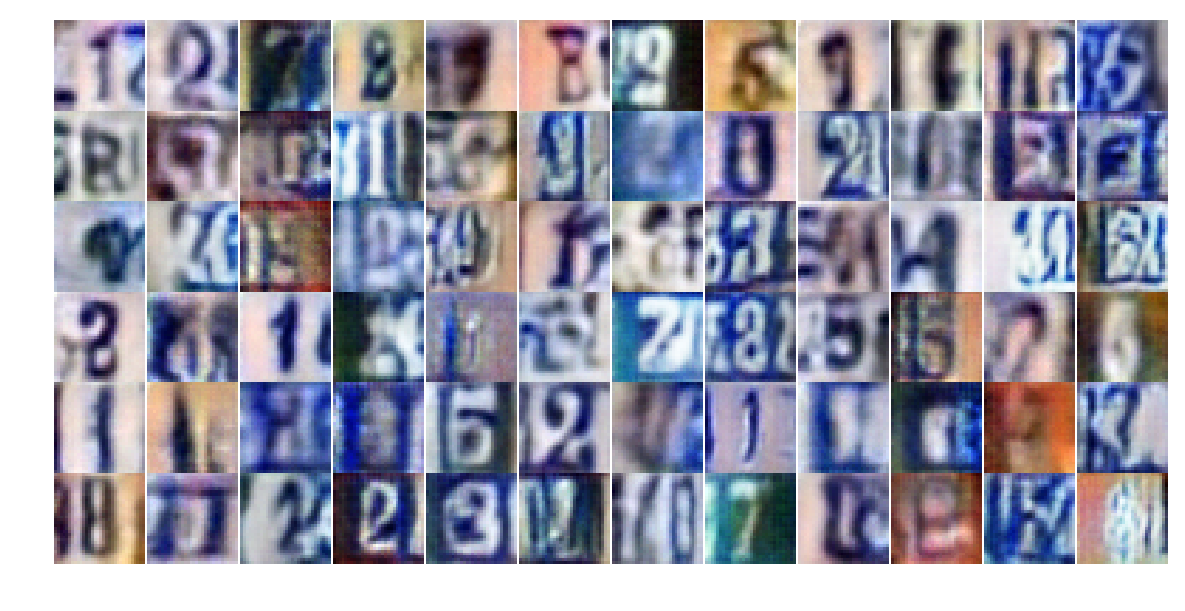

In [29]:
imageDisplayer.show_generated_samples(-1, samples, 6, 12, figsize=(10,5))